# Parameter recovery

This notebook runs parameter recovery tests for the model used in all the main analysis. This is the model-based learner model that assumes participants are learning the tasks' transition structure and using this to make model-based decisions.

In [29]:
import json
import os

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from model_fit_tools.plotting import *
from simulation_based_inference.npe import NPEModel

from transition_uncertainty.beta_models import *
from transition_uncertainty.modelling_utils import (
    generate_simulation_parameters,
    load_task_spec,
    repeat_for_all_subjects,
    run_model_recovery,
    simulate_model_with_params,
)
from transition_uncertainty.plotting import plot_recovery_results
from transition_uncertainty.style import set_style
from transition_uncertainty.utils import check_directories

# Make sure we're in the right directory
check_directories()

set_style("style.mplstyle")

Font Heebo already available in Matplotlib.
Matplotlib style set to: style.mplstyle with font Heebo


## Load in task spec

First, we load in the details of the task (e.g., the outcomes on each trial).

In [2]:
# Load task specification
(
    second_stage_states,
    second_stage_state_probs,
    rewards,
    reward_probs,
    available_side,
) = load_task_spec("data/task_spec")

# Determine the number of trials from the shape of the loaded data
N_TRIALS = second_stage_states.shape[1]

## Simulate data

We then use this information to simulate data from the model with a range of parameter values.

In [18]:
n_subs = 200
task_spec_path = "data/task_spec"

# Generate simulation parameters and unpack the returned values.
(
    second_stage_states_all,
    rewards_all,
    reward_probs_all,
    available_side_all,
    available_side,
    starting_value_estimate,
    starting_transition_prob_estimate,
    params_dict,
    true_params_array,
) = generate_simulation_parameters(n_subs, task_spec_path)

# Parameters that are common across all model types
common_params = [
    params_dict["temperature"],
    starting_value_estimate,
    starting_transition_prob_estimate,
    second_stage_states_all,
    reward_probs_all,
    rewards_all,
    available_side_all,
]

# Simulate data for each model

# Specify models - we only use the winning model as it's the one we use in all
# the main analyses
models = ["mb_only"]

# Dictionary to store simulated data
simulated_data_dict = {}

# Loop through models and simulate data
for model in models:
    simulated_data_dict[model] = simulate_model_with_params(
        model, params_dict, available_side, common_params
    )

    # Remove confidence trials
    simulated_data_dict[model] = simulated_data_dict[model][
        ..., available_side[0, :] == -1
    ]

## Load in trained models

We next load in the trained simulation-based inference (SBI) neural network model that we use to fit the model to the data.

In [19]:
from transition_uncertainty.modelling_utils import find_trained_models

# Get the trained models
trained_models = find_trained_models(models, "models")

/scratch/users/user/miniconda3/envs/tu_test_39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b

## Sample

We then sample from the posterior of the model to estimate the parameters that generated the data.

In [20]:
# Loop through models and sample parameters
sampled_params_dict = {}

for model in models:
    print("Sampling parameters for model: {}".format(model))
    sampled_params_dict[model] = trained_models[model].sample(
        simulated_data_dict[model], n_samples=1000
    )

Sampling parameters for model: mb_only


  0%|                                                                                                                                                      | 0/200 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 31.44it/s]


## Plot the results

Finally, we plot the results to see how well the model can recover the parameters that generated the data.

We use three plots:
1. A scatter plot of the true vs. recovered parameters. This allows us to see any areas where the model fails to recover parameter values. The model does a reasonably good job here the majority of points are close to the diagonal. However we can see that some participants with lower values for `$\tau_{prob}$ and $temperature$ are poorly estimated. Overall, however the correlation between the true and recovered parameters is high indicating that the model is doing a good job of recovering the parameters.
2. The posterior probability-probability plot. This gives us an idea of how well calibrated the full posterior is.
3. A confusion matrix. This shows us how identifiable each parameter is. We can see that we get a slight tradeoff between $temperature$ and $\tau_{prob}$ (this is quite common) but overall the parameters are well identified.

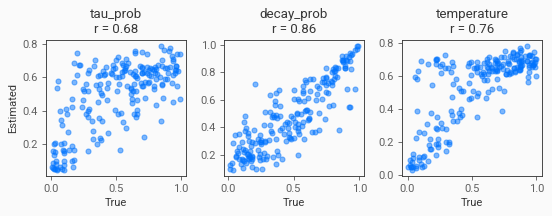

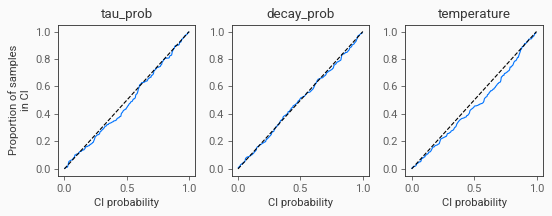

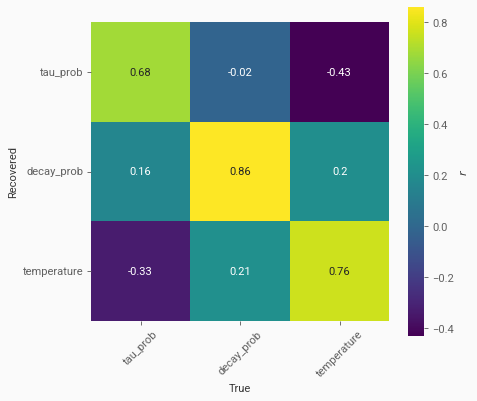

In [28]:
plot_recovery_results(
    "mb_only",
    true_params_array,
    sampled_params_dict,
    plot_recovery_kwargs={"scatter_kwargs": {"alpha": 0.5,'s': 20}},
)